In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import os, sys

In [3]:
import pandas as pd
from loguru import logger

In [4]:
sys.path.append('..')

from pyMultiOmics.constants import GENES, PROTEINS, COMPOUNDS, INFERENCE_T_TEST, DANIO_RERIO
from pyMultiOmics.mapping import Mapper
from pyMultiOmics.common import set_log_level_info, download_file, extract_zip_file
from pyMultiOmics.analysis import AnalysisPipeline
from pyMultiOmics.query import QueryBuilder, Entity, Connected, Select, SignificantDE, Info
from pyMultiOmics.info import get_info
from pyMultiOmics.base import SingleOmicsData, MultiOmicsData

from plotly import express as px

2022-03-24 14:38:15.243 | WARNING  | pyMultiOmics.reactome:get_neo4j_driver:14 - Using a default neo4j server: bolt://localhost:7687
2022-03-24 14:38:15.244 | WARNING  | pyMultiOmics.reactome:get_neo4j_driver:19 - Using a default neo4j username or password: neo4j
2022-03-24 14:38:15.244 | INFO     | pyMultiOmics.reactome:get_neo4j_driver:24 - Created graph database driver for bolt://localhost:7687 (neo4j)


# Demonstration of pyMultiOmics

## Load the processed Zebrafish data from [1]

[1] [Rabinowitz, Jeremy S., et al. "Transcriptomic, proteomic, and metabolomic landscape of positional memory in the caudal fin of zebrafish." Proceedings of the National Academy of Sciences 114.5 (2017): E717-E726.](https://www.pnas.org/content/114/5/E717.short)

In [5]:
url = 'https://github.com/glasgowcompbio/pyMultiOmics-data/raw/main/zebrafish_data.zip'
out_file = download_file(url)
extract_zip_file(out_file)

2022-03-24 14:38:16.333 | INFO     | pyMultiOmics.common:download_file:59 - Downloading zebrafish_data.zip
1.75kKB [00:00, 11.5kKB/s]                                                                                              
2022-03-24 14:38:16.511 | INFO     | pyMultiOmics.common:extract_zip_file:71 - Extracting zebrafish_data.zip
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 554.43it/s]
2022-03-24 14:38:16.546 | INFO     | pyMultiOmics.common:extract_zip_file:77 - Deleting zebrafish_data.zip


In [6]:
DATA_FOLDER = os.path.abspath(os.path.join('zebrafish_data'))
DATA_FOLDER

'/Users/joewandy/Work/git/pyMultiOmics/notebooks/zebrafish_data'

Read transcriptomics data (identified by their gene ids)

In [7]:
gene_data = pd.read_csv(os.path.join(DATA_FOLDER, 'gene_data_combined.csv'), index_col='Identifier')
gene_design = pd.read_csv(os.path.join(DATA_FOLDER, 'gene_design.csv'), index_col='sample')

Read proteomics data

In [8]:
protein_data = pd.read_csv(os.path.join(DATA_FOLDER, 'protein_data.csv'), index_col='Uniprot')
protein_design = pd.read_csv(os.path.join(DATA_FOLDER, 'protein_design.csv'), index_col='sample')

Read metabolomics data

In [9]:
compound_data = pd.read_csv(os.path.join(DATA_FOLDER, 'compound_data_chebi.csv'), index_col='Identifier')
compound_design = pd.read_csv(os.path.join(DATA_FOLDER, 'compound_design.csv'), index_col='sample')

In [10]:
set_log_level_info()

1

## Create multi-omics container

In [11]:
transcript_data = SingleOmicsData(GENES, gene_data, gene_design)
transcript_data

genes data with (31953, 15) measurements

In [12]:
protein_data = SingleOmicsData(PROTEINS, protein_data, protein_design)
protein_data

proteins data with (3061, 12) measurements

In [13]:
compound_data = SingleOmicsData(COMPOUNDS, compound_data, compound_design)
compound_data

compounds data with (124, 18) measurements

In [14]:
publication = 'Rabinowitz, Jeremy S., et al. "Transcriptomic, proteomic, and metabolomic landscape of positional memory in the caudal fin of zebrafish." Proceedings of the National Academy of Sciences 114.5 (2017): E717-E726.'
url = 'https://www.nature.com/articles/s41591-019-0719-5'

In [15]:
mo = MultiOmicsData(publication=publication, url=url)
mo.add_data([transcript_data, protein_data, compound_data])
mo

Multi-omics data container
- publication: Rabinowitz, Jeremy S., et al. "Transcriptomic, proteomic, and metabolomic landscape of positional memory in the caudal fin of zebrafish." Proceedings of the National Academy of Sciences 114.5 (2017): E717-E726.
- URL: https://www.nature.com/articles/s41591-019-0719-5
- Views: 3 modalities
	 - genes data with (31953, 15) measurements
	 - proteins data with (3061, 12) measurements
	 - compounds data with (124, 18) measurements

## Create a mapping object

The mapping object uses Reactome to map the different biological entities in the data:
- Transcripts (or genes) are connected to the proteins they encode
- Proteins and compounds are connected to reactions they're involved in
- Reactions are connected to pathways

In [16]:
mapping = Mapper(mo, DANIO_RERIO, metabolic_pathway_only=True)
mapping.build()

2022-03-24 14:38:17.009 | INFO     | pyMultiOmics.functions:remove_dupes:385 - Removing 0 rows with duplicate identifiers
2022-03-24 14:38:17.010 | INFO     | pyMultiOmics.functions:reactome_mapping:78 - There are 124 observed compound ids
2022-03-24 14:38:17.010 | INFO     | pyMultiOmics.functions:reactome_mapping:81 - Mapping genes -> proteins
2022-03-24 14:38:20.156 | INFO     | pyMultiOmics.functions:reactome_mapping:86 - Mapping proteins -> reactions
2022-03-24 14:38:23.827 | INFO     | pyMultiOmics.functions:reactome_mapping:94 - Mapping compounds -> reactions
2022-03-24 14:38:25.270 | INFO     | pyMultiOmics.functions:reactome_mapping:100 - Mapping reactions -> pathways
2022-03-24 14:38:25.747 | INFO     | pyMultiOmics.functions:reactome_mapping:111 - Mapping reactions -> proteins
2022-03-24 14:38:29.105 | INFO     | pyMultiOmics.functions:reactome_mapping:118 - Mapping reactions -> compounds
2022-03-24 14:38:31.793 | INFO     | pyMultiOmics.functions:reactome_mapping:130 - Mapp

## DE analysis

In [17]:
ap = AnalysisPipeline(mo, mapping)

In [18]:
method = INFERENCE_T_TEST
ap.run_de(method, GENES, 'Distal', 'Proximal')
ap.run_de(method, GENES, 'Distal', 'Middle')
ap.run_de(method, GENES, 'Proximal', 'Middle')

2022-03-24 14:38:52.355 | INFO     | pyMultiOmics.pipelines:run_ttest:71 - t-test case is Distal, control is Proximal
2022-03-24 14:38:57.528 | INFO     | pyMultiOmics.pipelines:run_ttest:71 - t-test case is Distal, control is Middle
2022-03-24 14:39:02.729 | INFO     | pyMultiOmics.pipelines:run_ttest:71 - t-test case is Proximal, control is Middle


In [19]:
method = INFERENCE_T_TEST
ap.run_de(method, PROTEINS, 'Distal', 'Proximal')
ap.run_de(method, PROTEINS, 'Distal', 'Middle')
ap.run_de(method, PROTEINS, 'Proximal', 'Middle')

ap.run_de(method, COMPOUNDS, 'Distal', 'Proximal')
ap.run_de(method, COMPOUNDS, 'Distal', 'Middle')
ap.run_de(method, COMPOUNDS, 'Proximal', 'Middle')

2022-03-24 14:39:08.000 | INFO     | pyMultiOmics.pipelines:run_ttest:71 - t-test case is Distal, control is Proximal
2022-03-24 14:39:08.594 | INFO     | pyMultiOmics.pipelines:run_ttest:71 - t-test case is Distal, control is Middle
2022-03-24 14:39:09.171 | INFO     | pyMultiOmics.pipelines:run_ttest:71 - t-test case is Proximal, control is Middle
2022-03-24 14:39:09.737 | INFO     | pyMultiOmics.pipelines:run_ttest:71 - t-test case is Distal, control is Proximal
2022-03-24 14:39:09.770 | INFO     | pyMultiOmics.pipelines:run_ttest:71 - t-test case is Distal, control is Middle
2022-03-24 14:39:09.803 | INFO     | pyMultiOmics.pipelines:run_ttest:71 - t-test case is Proximal, control is Middle


## Query results

Retrieve a single node

In [20]:
node_id = '15366'
res = QueryBuilder(ap) \
        .add(Entity(node_id)) \
        .run()
res

display_name  data_type  observed
entity_id                                  
15366      Acetic acid  compounds     False

Retrieve multiple nodes

In [21]:
node_id = ['15366', 'ENSDARG00000037781', 'F1QAA7']
res = QueryBuilder(ap) \
        .add(Entity(node_id)) \
        .run()
res

display_name  data_type  observed
entity_id                                           
15366               Acetic acid  compounds     False
ENSDARG00000037781        Acss2      genes      True
F1QAA7                   F1QAA7   proteins      True

Retrieve nodes connected to a single node

In [22]:
query_id = 'F1QAA7'
res = QueryBuilder(ap) \
        .add(Entity(query_id)) \
        .add(Connected()) \
        .run()
res

display_name  \
entity_id                                                               
ENSDARG00000037781                                              Acss2   
456215                                  Adenosine 5-monophosphate(2-)   
57287                                                  Coenzyme a(4-)   
30616                                                         Atp(4-)   
15366                                                     Acetic acid   
57288                                                  Acetyl-coa(4-)   
33019                                                 Diphosphate(3-)   
R-DRE-71735         Acetate + coa + atp => acetyl-coa + amp + pyro...   
R-DRE-71384                                         Ethanol oxidation   

                    data_type observed source_id  
entity_id                                         
ENSDARG00000037781      genes     True    F1QAA7  
456215              compounds    False    F1QAA7  
57287               compounds    False    F1QAA7  
30616               compounds    False    F1QAA7  
15366               compounds    False    F1QAA7  
57288               compounds    False    F1QAA7  
33019               compounds    False    F1QAA7  
R-DRE-71735         reactions     None    F1QAA7  
R-DRE-71384          pathways     None    F1QAA7

Retrieve top-10 significantly changing genes

In [23]:
case = 'Distal'
control = 'Proximal'
pval = 0.05
fc_lte = -2
fc_gte = 2
N = 20

In [24]:
res = QueryBuilder(ap) \
        .add(Select(GENES)) \
        .add(SignificantDE(case, control, pval, fc_lte=fc_lte, fc_gte=fc_gte, N=N)) \
        .run()
res

display_name data_type  observed  \
ENSDARG00000045854             Fgf23     genes      True   
ENSDARG00000071091            Chrm3a     genes      True   
ENSDARG00000104259    Cabz01072885.1     genes      True   
ENSDARG00000005522            Galr1a     genes      True   
ENSDARG00000062758        Cr352265.1     genes      True   
ENSDARG00000093491    Si:dkey-78l4.8     genes      True   
ENSDARG00000076345           Taar19p     genes      True   
ENSDARG00000077290            Mmp25a     genes      True   
ENSDARG00000037946               Prl     genes      True   
ENSDARG00000093738             Pth1a     genes      True   
ENSDARG00000096424           Ighv2-2     genes      True   
ENSDARG00000102336            Slc5a7     genes      True   
ENSDARG00000070038             Rbp2a     genes      True   
ENSDARG00000067859        Scospondin     genes      True   
ENSDARG00000008306              Rdh5     genes      True   
ENSDARG00000100258  Si:dkeyp-104b3.2     genes      True   
ENSDARG00000093089             Tac3a     genes      True   
ENSDARG00000038894             Tmx3a     genes      True   
ENSDARG00000039067           Srd5a2b     genes      True   
ENSDARG00000076270          Adamts13     genes      True   

                    padj_Distal_vs_Proximal  FC_Distal_vs_Proximal  
ENSDARG00000045854             3.569550e-10              24.000289  
ENSDARG00000071091             3.307603e-11              22.486196  
ENSDARG00000104259             2.782933e-10              20.545646  
ENSDARG00000005522             2.091894e-09              20.531569  
ENSDARG00000062758             5.800455e-10              20.055404  
ENSDARG00000093491             5.800455e-10              20.055404  
ENSDARG00000076345             6.804488e-11              20.002797  
ENSDARG00000077290             2.682582e-14              19.867183  
ENSDARG00000037946             3.736906e-10              19.689389  
ENSDARG00000093738             3.736906e-10              19.689389  
ENSDARG00000096424             2.455671e-09             -21.508830  
ENSDARG00000102336             5.646605e-09             -21.542885  
ENSDARG00000070038             1.821398e-10             -21.882546  
ENSDARG00000067859             1.625297e-10             -22.444017  
ENSDARG00000008306             7.680307e-11             -22.449311  
ENSDARG00000100258             2.760891e-09             -22.482546  
ENSDARG00000093089             3.569550e-10             -22.875241  
ENSDARG00000038894             4.745826e-10             -23.095898  
ENSDARG00000039067             6.493330e-11             -23.483296  
ENSDARG00000076270             6.923704e-11             -23.815791

Find the compounds that are connected to the DE genes above

In [25]:
res = QueryBuilder(ap) \
        .add(Select(GENES)) \
        .add(SignificantDE(case, control, pval, fc_lte=fc_lte, fc_gte=fc_gte, N=N)) \
        .add(Connected(data_type=COMPOUNDS)) \
        .run()
res

display_name  data_type  observed  \
entity_id                                                               
17336                          All-trans-retinol  compounds     False   
45021                            Palmitoyl group  compounds     False   
70760                   All-trans-retinyl oleate  compounds     False   
70762                All-trans-retinyl linoleate  compounds     False   
70761                 All-trans-retinyl stearate  compounds     False   
26753                             Stearoyl group  compounds     False   
17616                All-trans-retinyl palmitate  compounds     False   
25667                               Oleoyl group  compounds     False   
32386                            Linoleoyl group  compounds     False   
17898                          All-trans-retinal  compounds     False   
15378                                     Hydron  compounds     False   
58349                                   Nadp(3-)  compounds     False   
57783                                  Nadph(4-)  compounds     False   
16330      17beta-hydroxy-5alpha-androstan-3-one  compounds     False   
57783                                  Nadph(4-)  compounds     False   
15378                                     Hydron  compounds     False   
58349                                   Nadp(3-)  compounds     False   
17347                               Testosterone  compounds     False   

                    source_id  
entity_id                      
17336      ENSDARG00000070038  
45021      ENSDARG00000070038  
70760      ENSDARG00000070038  
70762      ENSDARG00000070038  
70761      ENSDARG00000070038  
26753      ENSDARG00000070038  
17616      ENSDARG00000070038  
25667      ENSDARG00000070038  
32386      ENSDARG00000070038  
17898      ENSDARG00000070038  
15378      ENSDARG00000070038  
58349      ENSDARG00000070038  
57783      ENSDARG00000070038  
16330      ENSDARG00000039067  
57783      ENSDARG00000039067  
15378      ENSDARG00000039067  
58349      ENSDARG00000039067  
17347      ENSDARG00000039067

### Retrieve entity info

In [26]:
res = QueryBuilder(ap) \
        .add(Select(GENES)) \
        .add(SignificantDE(case, control, pval, fc_lte=fc_lte, fc_gte=fc_gte, N=N)) \
        .add(Connected()) \
        .add(Info()) \
        .run()
res

display_name  data_type  \
entity_id                                                                  
Q1L8M3                                                 Q1L8M3   proteins   
X1WHZ7                                                 X1WHZ7   proteins   
A0A0G2L3I9                                         A0A0G2L3I9   proteins   
F1QSA8                                                 F1QSA8   proteins   
F1QV82                                                 F1QV82   proteins   
F1Q925                                                 F1Q925   proteins   
F1QJL9                                                 F1QJL9   proteins   
I3IT28                                                 I3IT28   proteins   
F1R0Y2                                                 F1R0Y2   proteins   
F1QMK0                                                 F1QMK0   proteins   
M9MMF1                                                 M9MMF1   proteins   
A0A0G2KQP1                                         A0A0G2KQP1   proteins   
Q8UVG6                                                 Q8UVG6   proteins   
17336                                       All-trans-retinol  compounds   
45021                                         Palmitoyl group  compounds   
70760                                All-trans-retinyl oleate  compounds   
70762                             All-trans-retinyl linoleate  compounds   
70761                              All-trans-retinyl stearate  compounds   
26753                                          Stearoyl group  compounds   
17616                             All-trans-retinyl palmitate  compounds   
25667                                            Oleoyl group  compounds   
32386                                         Linoleoyl group  compounds   
17898                                       All-trans-retinal  compounds   
15378                                                  Hydron  compounds   
58349                                                Nadp(3-)  compounds   
57783                                               Nadph(4-)  compounds   
R-DRE-975633                              Atrol binds to rbp2  reactions   
R-DRE-975608   Lrat esterifies rbp2:atrol and facyls to atres  reactions   
R-DRE-2399913                             Atral binds to rbp2  reactions   
R-DRE-975629           Rdh11 reduces rbp2:atral to rbp2:atrol  reactions   
R-DRE-2855252            Akrs reduce rbp2:atral to rbp2:atrol  reactions   
R-DRE-975634                Retinoid metabolism and transport   pathways   
F1QSL8                                                 F1QSL8   proteins   
F1RCW4                                                 F1RCW4   proteins   
A0A0R4IZN3                                         A0A0R4IZN3   proteins   
E9QE01                                                 E9QE01   proteins   
A0A2R8QHZ9                                         A0A2R8QHZ9   proteins   
F8W397                                                 F8W397   proteins   
16330                   17beta-hydroxy-5alpha-androstan-3-one  compounds   
57783                                               Nadph(4-)  compounds   
15378                                                  Hydron  compounds   
58349                                                Nadp(3-)  compounds   
17347                                            Testosterone  compounds   
R-DRE-9705713            Srd5a2 dehydrogenates test to dhtest  reactions   
R-DRE-193048                            Androgen biosynthesis   pathways   
A0A286Y999                                         A0A286Y999   proteins   

              observed           source_id  \
entity_id                                    
Q1L8M3           False  ENSDARG00000045854   
X1WHZ7           False  ENSDARG00000071091   
A0A0G2L3I9       False  ENSDARG00000104259   
F1QSA8           False  ENSDARG00000005522   
F1QV82           False  ENSDARG00000062758   
F1Q925           False  ENSDARG00000093491   
F1QJL9           False  ENSDARG0

An alternative way to retrieve entity info

In [27]:
entity_ids = ['ENSDARG00000091254', 'F1QAA7', '15378', 'R-DRE-469659', 'R-DRE-174403']
data_types = ['genes', 'proteins', 'compounds', 'reactions', 'pathways']
for entity_id, data_type in zip(entity_ids, data_types):
    print(entity_id, data_type)
    print(get_info(entity_id, data_type))
    print()

ENSDARG00000091254 genes
{'infos': [{'key': 'Description', 'value': 'si:ch73-59p9.2 '}, {'key': 'Species', 'value': 'danio_rerio'}], 'links': [{'text': 'Link to Ensembl', 'href': 'https://www.ensembl.org/id/ENSDARG00000091254'}, {'text': 'Link to GeneCard', 'href': 'https://www.genecards.org/cgi-bin/carddisp.pl?gene=si:ch73-59p9.2'}, {'text': 'Transcript: si:ch73-59p9.2-201', 'href': 'https://www.ensembl.org/id/ENSDART00000111526'}], 'images': []}

F1QAA7 proteins
{'infos': [{'key': 'Name', 'value': 'Propionate--CoA ligase'}, {'key': 'EC Number', 'value': 'EC6.2.1.17'}, {'key': 'Catalytic Activity', 'value': '\n\nATP + CoA + propanoate = AMP + diphosphate + propanoyl-CoA\n\n\n\n\n\n\n\n\n\n\n\n\n'}, {'key': 'Catalytic Activity', 'value': '\n\nacetate + ATP + CoA = acetyl-CoA + AMP + diphosphate\n\n\n\n\n\n\n\n\n\n\n\n\n'}, {'key': 'Gene_ontologies', 'value': 'acetate-CoA ligase activity; propionate-CoA ligase activity'}], 'links': [{'text': 'Link to UniProt', 'href': 'http://www.unipro

### Plot some heatmap using Plotly

In [28]:
res = QueryBuilder(ap) \
        .add(Select(GENES)) \
        .add(SignificantDE(case, control, pval, fc_lte=fc_lte, fc_gte=fc_gte, N=N)) \
        .run()
res

display_name data_type  observed  \
ENSDARG00000045854             Fgf23     genes      True   
ENSDARG00000071091            Chrm3a     genes      True   
ENSDARG00000104259    Cabz01072885.1     genes      True   
ENSDARG00000005522            Galr1a     genes      True   
ENSDARG00000062758        Cr352265.1     genes      True   
ENSDARG00000093491    Si:dkey-78l4.8     genes      True   
ENSDARG00000076345           Taar19p     genes      True   
ENSDARG00000077290            Mmp25a     genes      True   
ENSDARG00000037946               Prl     genes      True   
ENSDARG00000093738             Pth1a     genes      True   
ENSDARG00000096424           Ighv2-2     genes      True   
ENSDARG00000102336            Slc5a7     genes      True   
ENSDARG00000070038             Rbp2a     genes      True   
ENSDARG00000067859        Scospondin     genes      True   
ENSDARG00000008306              Rdh5     genes      True   
ENSDARG00000100258  Si:dkeyp-104b3.2     genes      True   
ENSDARG00000093089             Tac3a     genes      True   
ENSDARG00000038894             Tmx3a     genes      True   
ENSDARG00000039067           Srd5a2b     genes      True   
ENSDARG00000076270          Adamts13     genes      True   

                    padj_Distal_vs_Proximal  FC_Distal_vs_Proximal  
ENSDARG00000045854             3.569550e-10              24.000289  
ENSDARG00000071091             3.307603e-11              22.486196  
ENSDARG00000104259             2.782933e-10              20.545646  
ENSDARG00000005522             2.091894e-09              20.531569  
ENSDARG00000062758             5.800455e-10              20.055404  
ENSDARG00000093491             5.800455e-10              20.055404  
ENSDARG00000076345             6.804488e-11              20.002797  
ENSDARG00000077290             2.682582e-14              19.867183  
ENSDARG00000037946             3.736906e-10              19.689389  
ENSDARG00000093738             3.736906e-10              19.689389  
ENSDARG00000096424             2.455671e-09             -21.508830  
ENSDARG00000102336             5.646605e-09             -21.542885  
ENSDARG00000070038             1.821398e-10             -21.882546  
ENSDARG00000067859             1.625297e-10             -22.444017  
ENSDARG00000008306             7.680307e-11             -22.449311  
ENSDARG00000100258             2.760891e-09             -22.482546  
ENSDARG00000093089             3.569550e-10             -22.875241  
ENSDARG00000038894             4.745826e-10             -23.095898  
ENSDARG00000039067             6.493330e-11             -23.483296  
ENSDARG00000076270             6.923704e-11             -23.815791

In [29]:
data_type = GENES
analysis = ap.get_de_analysis(data_type, case, control)
wi = analysis.wi
data_df, design_df = wi.data_df, wi.design_df
data_df

US-1584693  US-1584700  US-1584706  US-1584712  \
Identifier                                                           
ENSDARG00000000001        51.0        40.0        69.0        78.0   
ENSDARG00000000002       283.0       129.0       164.0       269.0   
ENSDARG00000000018       545.0       503.0       547.0       387.0   
ENSDARG00000000019       437.0       469.0       538.0       557.0   
ENSDARG00000000068       266.0       249.0       247.0       236.0   
...                        ...         ...         ...         ...   
ENSDARG00000105304         1.0         0.6         2.0         1.0   
ENSDARG00000105305        14.0        20.0        15.0        21.0   
ENSDARG00000105306         6.0         1.0         1.0         2.0   
ENSDARG00000105307         7.0         8.0         4.0         6.0   
ENSDARG00000105308        39.0        47.0        28.0        67.0   

                    US-1584722  US-1584724  US-1584725  US-1584732  \
Identifier                                                           
ENSDARG00000000001        89.0        47.0        88.0        86.0   
ENSDARG00000000002       211.0       171.0       146.0       256.0   
ENSDARG00000000018       332.0       559.0       623.0       499.0   
ENSDARG00000000019       550.0       404.0       544.0       443.0   
ENSDARG00000000068       195.0       247.0       283.0       259.0   
...                        ...         ...         ...         ...   
ENSDARG00000105304         0.4         0.4         1.0         0.4   
ENSDARG00000105305        21.0        20.0        30.0        25.0   
ENSDARG00000105306         2.0         3.0         1.0         3.0   
ENSDARG00000105307         2.2         3.0         4.0         3.0   
ENSDARG00000105308        54.0        43.0        49.0        31.0   

                    US-1584738  US-1584744  US-1584752  US-1584753  \
Identifier                                                           
ENSDARG00000000001       110.0        55.0        54.0        58.0   
ENSDARG00000000002       283.0       150.0       223.0       142.0   
ENSDARG00000000018       436.0       488.0       549.0       462.0   
ENSDARG00000000019       623.0       502.0       487.0       470.0   
ENSDARG00000000068       299.0       232.0       249.0       231.0   
...                        ...         ...         ...         ...   
ENSDARG00000105304         1.0         0.6         1.0         0.6   
ENSDARG00000105305        34.0        27.0        16.0        20.0   
ENSDARG00000105306         1.0         6.0         3.0         1.0   
ENSDARG00000105307         1.0         2.0         5.0         4.0   
ENSDARG00000105308        46.0        37.0        30.0        33.0   

                    US-1584754  US-1584758  US-1584765  
Identifier                                              
ENSDARG00000000001       104.0        43.0        72.0  
ENSDARG00000000002       272.0       260.0       256.0  
ENSDARG00000000018       287.0       495.0       299.0  
ENSDARG00000000019       460.0       329.0       480.0  
ENSDARG00000000068       236.0       274.0       241.0  
...                        ...         ...         ...  
ENSDARG00000105304         0.4         0.4         0.4  
ENSDARG00000105305        24.0        24.0        18.0  
ENSDARG00000105306         4.0         1.0         3.0  
ENSDARG00000105307         1.0         4.0         3.0  
ENSDARG00000105308        54.0        39.0        49.0  

[28024 rows x 15 columns]

In [30]:
case_group = design_df[design_df['group'] == case].index.values.tolist()
control_group = design_df[design_df['group'] == control].index.values.tolist()
selection = case_group + control_group
selection

['US-1584738',
 'US-1584722',
 'US-1584712',
 'US-1584754',
 'US-1584765',
 'US-1584752',
 'US-1584732',
 'US-1584724',
 'US-1584693',
 'US-1584758']

In [31]:
heatmap_df = wi.data_df.loc[res.index.values]
heatmap_df = heatmap_df[selection]
heatmap_df

US-1584738  US-1584722  US-1584712  US-1584754  \
Identifier                                                           
ENSDARG00000045854   28.000000   22.000000   27.000000    8.000000   
ENSDARG00000071091    5.000000    4.000000    7.000000    5.000000   
ENSDARG00000104259    3.000000    1.400000    1.000000    2.000000   
ENSDARG00000005522    5.000000    1.000000    1.000000    1.600000   
ENSDARG00000062758    3.000000    1.000000    0.800000    0.800000   
ENSDARG00000093491    0.800000    0.800000    0.800000    3.000000   
ENSDARG00000076345    1.000000    1.000000    2.000000    0.800000   
ENSDARG00000077290    1.000000    1.000000    1.000000    0.800000   
ENSDARG00000037946    0.600000    1.000000    2.000000    0.600000   
ENSDARG00000093738    0.600000    0.600000    2.000000    1.000000   
ENSDARG00000096424    0.000001    0.000001    0.000001    0.000001   
ENSDARG00000102336    0.000001    0.000001    0.000001    0.000001   
ENSDARG00000070038    0.000001    0.000001    0.000001    0.000001   
ENSDARG00000067859    0.000001    0.000001    0.000001    0.000001   
ENSDARG00000008306    0.000001    0.000001    0.000001    0.000001   
ENSDARG00000100258    0.000001    0.000001    0.000001    0.000001   
ENSDARG00000093089    0.000001    0.000001    0.000001    0.000001   
ENSDARG00000038894    0.000001    0.000001    0.000001    0.000001   
ENSDARG00000039067    0.000001    0.000001    0.000001    0.000001   
ENSDARG00000076270    0.000001    0.000001    0.000001    0.000001   

                    US-1584765  US-1584752  US-1584732  US-1584724  \
Identifier                                                           
ENSDARG00000045854   10.000000    0.000001    0.000001    0.000001   
ENSDARG00000071091   10.000000    0.000001    0.000001    0.000001   
ENSDARG00000104259    1.000000    0.000001    0.000001    0.000001   
ENSDARG00000005522    1.000000    0.000001    0.000001    0.000001   
ENSDARG00000062758    0.800000    0.000001    0.000001    0.000001   
ENSDARG00000093491    1.000000    0.000001    0.000001    0.000001   
ENSDARG00000076345    0.800000    0.000001    0.000001    0.000001   
ENSDARG00000077290    1.000000    0.000001    0.000001    0.000001   
ENSDARG00000037946    0.600000    0.000001    0.000001    0.000001   
ENSDARG00000093738    0.600000    0.000001    0.000001    0.000001   
ENSDARG00000096424    0.000001    2.600000    1.000000    2.600000   
ENSDARG00000102336    0.000001    1.000000    3.200000    2.000000   
ENSDARG00000070038    0.000001    3.000000    2.000000    6.000000   
ENSDARG00000067859    0.000001    7.000000    9.000000    4.000000   
ENSDARG00000008306    0.000001    4.000000    7.000000    4.000000   
ENSDARG00000100258    0.000001    6.000000   18.000000    4.000000   
ENSDARG00000093089    0.000001    7.200000    8.000000    3.000000   
ENSDARG00000038894    0.000001   11.000000    9.000000   13.000000   
ENSDARG00000039067    0.000001    7.000000   22.000000   12.000000   
ENSDARG00000076270    0.000001   26.000000   15.000000   20.000000   

                    US-1584693  US-1584758  
Identifier                                  
ENSDARG00000045854    0.000001    0.000001  
ENSDARG00000071091    0.000001    0.000001  
ENSDARG00000104259    0.000001    0.000001  
ENSDARG00000005522    0.000001    0.000001  
ENSDARG00000062758    0.000001    0.000001  
ENSDARG00000093491    0.000001    0.000001  
ENSDARG00000076345    0.000001    0.000001  
ENSDARG00000077290    0.000001    0.000001  
ENSDARG00000037946    0.000001    0.000001  
ENSDARG00000093738    0.000001    0.000001  
ENSDARG00000096424    7.000000    5.000000  
ENSDARG00000102336    3.200000   13.000000  
ENSDARG00000070038    6.000000    4.000000  
ENSDARG00000067859    8.000000    3.000000  
ENSDARG00000008306    5.000000   11.000000  
ENSDARG00000100258    2.000000    8.000000  
ENSDARG00000093089   12.000000   13.000000  
ENSDARG00000038894   15.000000    3.000000  
ENSDARG00000039067   12.000000   10.00

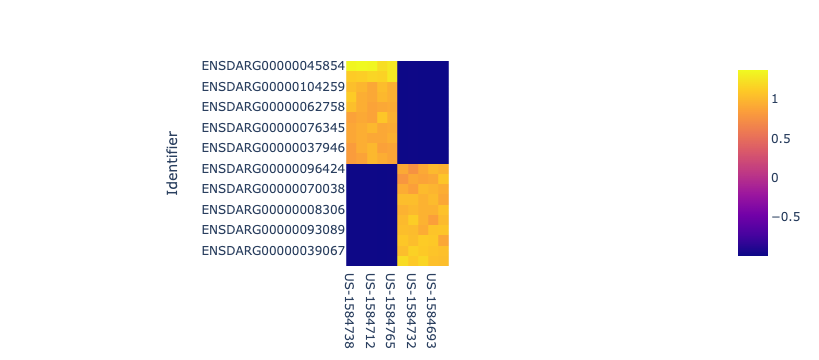

In [32]:
px.imshow(wi.standardize_df(heatmap_df, log=True, axis=0))